In [1]:
from __future__ import print_function
from __future__ import division

import make_dictionaries
import os
import math

questions = make_dictionaries.questions
function_dictionary = make_dictionaries.function_dictionary

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [3]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time

In [4]:
import params

source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
question_dictionary = params.question_dictionary
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.1 #np.log10(0.9)

#min_log_fv = np.log10(0.1)
#max_log_fv = np.log10(0.8)

Question to be debiased: t01_smooth_or_features


In [5]:
all_data = fits.getdata(source_directory + full_sample,1)
vl_data = fits.getdata(source_directory + volume_limited_sample,1)
all_data = Table(all_data)
vl_data = Table(vl_data)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded question dictionary...')
#function_dictionary = make_dictionaries.function_dictionary
print('Loaded function dictionary...')
# Stuff obtained from the voronoi code:
all_voronoi = fits.getdata(save_directory+'bins.fits',1)
all_voronoi = Table(all_voronoi)
vbins_table = fits.getdata(save_directory+'vbins_table.fits',1)
vbins_table = Table(vbins_table)
print('Loaded voronoi bins...')

Loaded galaxy data...
Loaded question dictionary...
Loaded function dictionary...
Loaded voronoi bins...


In [6]:
vbins_table['density'] = vbins_table['count_gals']/vbins_table['count_rect_bins']
sorted_indices = vbins_table.argsort('density')
densest_vbin = vbins_table[sorted_indices[-1]]['vbin']
average_vbin = vbins_table[sorted_indices[len(sorted_indices)//2]]['vbin']
densest_vbin, average_vbin

(1, 28)

In [7]:
# Make a table for writing in data if none already exist:
if os.path.isfile(save_directory+'full_sample_debiased.fits') is True:
    all_data_save = fits.getdata(save_directory+'full_sample_debiased.fits',1)
    all_data_save = Table(all_data_save)
else:
    all_data_save = Table()
    
if os.path.isfile(save_directory+'vl_sample_debiased.fits') is True:
    vl_data_save = fits.getdata(save_directory+'vl_sample_debiased.fits',1)
    vl_data_save = Table(vl_data_save)
else:
    vl_data_save = Table()

In [8]:
def make_figure_directory(name):
    full_name = 'figures/' + question + '/' + name + '/'
    if os.path.isdir(full_name) is False:
        os.mkdir(full_name)
        print('Made directory:' + full_name)
    return None

os.makedirs('figures/' + question + '/') if os.path.isdir('figures/' + question + '/') is False else None
for name in ['fitted_results','fit_setups','kc_fitted_functions','debiased_plots']:
    make_figure_directory(name)

In [9]:
## from 01_select.py

def select_data_arm_number(data,debiased,question,questions,N_cut=5,p_cut=0.5):
    
    pre_questions = questions[question]['pre_questions']
    pre_answers = questions[question]['pre_answers']
    
    strings = [pre_questions[s] + '_' + pre_answers[s] for s in range(len(pre_answers))]
    p_strings = [s + '_debiased' for s in strings]
    N_string = strings[-1] + '_count'

    p_values = np.ones(len(data))
    N_values = np.ones(len(data))

    for Q in p_strings:
        p_values = p_values*debiased[Q]
    N_values = N_values*data[N_string]

    select = (p_values > p_cut) & (N_values >= N_cut)
    
    print('{}/{} ({}%) galaxies selected in sample with p>{} and N>={}.'.format(np.sum(select),len(select),
                                                                               100*np.sum(select)/len(select),p_cut,N_cut))
    
    return select

In [10]:
## from 11_voronoi_assignment.py

def redshift_binning(data,voronoi_bins,question,questions,min_gals=50):
    
    answers = questions[question]['answers']
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    z_bins = np.zeros((len(morph_fv_cols), len(data)), np.int)

    for N in np.unique(voronoi_bins):
        inbin = voronoi_bins == N

        for m, fv_col in enumerate(morph_fv_cols):
            # Select bins such that >= min_gals objects
            # with at least one vote are in each bin
            has_morph = data[fv_col][inbin] > 0
            n_with_morph = (has_morph).sum()
            #n_zbins = n_with_morph / min_gals 
            #n_zbins = max(n_zbins, 5)
            n_zbins = 5
            z = redshift[inbin]
            z_with_morph = z[has_morph]
            z_with_morph.sort()
            bin_edges = np.linspace(0, len(z_with_morph)-1, n_zbins+1, dtype=np.int)
            z_edges = z_with_morph[bin_edges]
            z_edges[0] = 0
            z_edges[-1] = 1
            z_bins[m, inbin] = np.digitize(z, z_edges)

    return z_bins

In [11]:
def save_bin_assignments(v_bins, z_bins, question='t11_arms_number'):
    assignments = Table(data=[v_bins], names=['vbin'])
    for m in range(len(z_bins)):
        zcol = 'zbin_{}'.format(m)
        assignments[zcol] = z_bins[m]
    assignments.write(save_directory + 'bin_assignments_{}.fits'.format(question),
                      overwrite=True)
    return assignments

In [12]:
if questions[question]['pre_questions'] != None:
    select = select_data_arm_number(all_data,all_data_save,question,questions)
    data = all_data[select]
    voronoi = all_voronoi[select]

else:
    data = all_data
    voronoi = all_voronoi
    print('Primary question, so all {} galaxies used for debiasing.'.format(len(data)))

Primary question, so all 231138 galaxies used for debiasing.


In [13]:
redshift_bins = redshift_binning(data, voronoi['voronoi_bin'],question,questions)
bin_assignments = save_bin_assignments(voronoi['voronoi_bin'],redshift_bins,question)
print('Redshift bins assigned')

Redshift bins assigned


In [14]:
def chisq_fun(p, f, x, y):
    return ((f(x, *p) - y)**2).sum()

In [15]:
def plot_raw(ax, D, color):
    # Plot cumulative fractions for the raw data
    ax.plot(D['log10fv'], D['cumfrac'], '-', color=color, lw=2, alpha=0.2)


def plot_function(ax, f, x, p, color, style='--'):
    # Plot fitted function to cumulative fractions
    ax.plot(x, f(x, *p), style, color=color, lw=0.5)


def plot_guides(ax):
    # Plot guides at 20%, 50%, 80%
    x_guides = np.log10([0.2, 0.5, 0.8])
    y_guides = np.array([0, 1.05])
    for xg in x_guides:
        ax.plot([xg, xg], y_guides, color=[0, 0, 0], alpha=0.3)

        
def plot_limits(x, p=1, d=0.05):
    low, high = scoreatpercentile(x, (p, 100-p))
    diff = high-low
    low -= d * diff
    high += d * diff
    return low, high


def finish_vbin_plot(fig, ax, answerlabels, m, v):
    plot_guides(ax)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticks(np.arange(-1.5, 0.1, 0.5))
    ax.text(-1.9, 0.95, answerlabels[m],
            fontsize=10, ha='left')
    ax.set_ylim([0, 1.05])
    if m > 2:
        ax.set_xlabel(r'$\log(v_f)$')
    if m in (0, 3):
        ax.set_ylabel('Cumulative fraction')
    if m == 1:
        ax.set_title('Voronoi bin %02i' % v)
    fig.subplots_adjust(wspace=0, hspace=0)

In [64]:
def fit_vbin_function(data, bin_assignments, fit_setup,
                      question,questions,kc_fit_results=None,
                      plot=bins_to_plot,min_log_fv=min_log_fv,
                      even_sampling=True):
    # Output fitted function for each of the Voronoi bins,
    # arm numbers and redshift bins.
    
    start_time = time.time()
    
    answers = questions[question]['answers']
    answerlabels = questions[question]['answerlabels']

    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    vbins = bin_assignments['vbin']

    if kc_fit_results is not None:
        kcfunc, kparams, cparams, lparams,kclabel = kc_fit_results
    
    # Set up the list to write the parameters in to:
    param_data = []
    
    max_z_bins_to_plot = 5
    
    # Loop over Voronoi magnitude-size bins
    for v in np.unique(vbins):
        vselect = vbins == v
        data_v = data[vselect]
        bin_assignments_v = bin_assignments[vselect]

        if v in plot:
            fig,axarr = make_axes(n_morph=len(answers))
            x = np.linspace(-2,0,1000)

        # Loop over morphological categories
        for m, fv in enumerate(morph_fv_cols):
            z_bins = bin_assignments_v['zbin_{}'.format(m)]
            z_bins_unique = np.unique(z_bins)
            n_z_bins = len(z_bins_unique)
            z_bins_to_plot = z_bins_unique[::(n_z_bins // max_z_bins_to_plot) + 1]
            z_min = z_bins.min()
            z_max = z_bins.max()
            clr_diff = (1.0 / (z_max - z_min)) if z_max - z_min != 0 else 0

            # Loop over redshift slices
            for z in z_bins_unique:
                data_z = data_v[z_bins == z]
                n = len(data_z)
                clr_z = [min((z - 1) * clr_diff, 1), 0,
                         max(1 - (z - 1) * clr_diff, 0)]

                # Compute cumulative fraction
                D = data_z[[fv]]
                D.sort(fv)
                D['cumfrac'] = np.linspace(0, 1, n)
                #D = D[D[fv] > min_fv]
                D['log10fv'] = np.log10(D[fv])
                if even_sampling:
                    D_log10fv = np.log10(np.linspace(10**min_log_fv, 1, 100))
                    indices = np.searchsorted(D['log10fv'], D_log10fv)
                    D = D[indices.clip(0, len(D)-1)]
                else:
                    D = D[D['log10fv'] > min_log_fv]

                # Fit function to the cumulative fraction
                # Start fits off in roughly right place with sensible bounds
                func, p0, bounds = get_fit_setup(fit_setup, m)
                # Note that need to cast x and y to float64 in order
                # for minimisation to work correctly
                res = minimize(chisq_fun, p0,
                               args=(func,
                                     D['log10fv'].astype(np.float64),
                                     D['cumfrac'].astype(np.float64)),
                               bounds=bounds, method='SLSQP')
                p = res.x
                chi2nu = res.fun / (n - len(p))
                
                means = [data_z['PETROMAG_MR'].mean(),
                         np.log10(data_z['PETROR50_R_KPC']).mean(),
                         data_z['REDSHIFT_1'].mean()]
                                
                if v in plot and z in z_bins_to_plot:
                    ax = axarr[m]
                    plot_raw(ax, D, clr_z)
                    plot_function(ax, func, x, p, clr_z)
                    if kc_fit_results is not None:
                        kf = kcfunc(means, *kparams[m])
                        cf = kcfunc(means, *cparams[m])
                        lf = kcfunc(means, *lparams[m])
                        plot_function(ax, func, x, (kf, cf,lf), clr_z, style=':')

                if len(p) < 2:
                    p = np.array([p[0], 10])

                param_data.append([v, m, z] + means + p[:3].tolist() + # Maybe change output table here
                                  [chi2nu])

            if v in plot:
                finish_vbin_plot(fig, ax, answerlabels, m, v)
        if v in plot:
            
            suffix = '_kcfit{}'.format(kclabel) if kc_fit_results is not None else ''
            fig.savefig('figures/' + question + '/fitted_results/fit_{}_vbin{:02d}{}.pdf'.format(question, v, suffix),
                        dpi=100)
            plt.close()

    fit_vbin_results = Table(rows=param_data,
                             names=('vbin', 'answer', 'zbin', 'Mr',
                                    'R50', 'redshift', 'k', 'c','l', 'chi2nu'))
    fit_vbin_results.write(save_directory + 'fit_vbin_results_{}.fits'.format(question),
                           overwrite=True)
    
    print('All bins fitted! {}s in total'.format(time.time()-start_time))
    
    return fit_vbin_results

In [17]:
def get_fit_setup(fit_setup, m):
    def get_m(x):
        return x[m] if m in x.keys() else x[None]
    func = get_m(fit_setup['func'])
    p0 = get_m(fit_setup['p0'])
    bounds = get_m(fit_setup['bounds'])
    return func, p0, bounds

In [18]:
def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(5*x_dimension,5*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes

In [23]:
# Choose the best fit setup for arm number:

def make_setup_dictionary(data, question, questions, function_dictionary=function_dictionary,
                          bin_assignments=bin_assignments, vbin=None,
                          plot=True,min_log_fv=min_log_fv,max_log_fv=max_log_fv,
                          even_sampling=True):

    fit_setup = {}
    fit_setup['func'] = {None: None}
    fit_setup['bounds'] = {None: None}
    fit_setup['p0'] = {None:None}
    fit_setup['inverse'] = {None:None}

    n_morph = len(questions[question]['answers'])
    fig,axes = make_axes(n_morph)

    if vbin is not None:
        vbins = bin_assignments['vbin']
        vselect = vbins == vbin
        data = data[vselect]
    
    fractions = [question + '_' + s + '_weighted_fraction' for s in questions[question]['answers']]
    counts = [question + '_' + s + '_count' for s in questions[question]['answers']]

    for m in range(n_morph):
    
        p_values = np.log10(np.sort(data[fractions[m]]))
        n = len(p_values)
        cumfrac = np.linspace(0,1,n)
        D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
        # usually see a 'levelling off' at the low end, so don't fit below min_log_fv.
        if even_sampling:
            D_fit_log10fv = np.log10(np.linspace(10**min_log_fv, 1, 1000))
            indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
            D_fit = D[indices.clip(0, len(D)-1)]
        else:
            D_fit = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)] 

        axes[m].plot(D['log10fv'],D['cumfrac'],'k-',linewidth=2)
        
        chisqs = []
        best_kcs = []
        
        for f in range(len(function_dictionary['func'])):
        
            p0 = function_dictionary['p0'][f]
            func = function_dictionary['func'][f]
            bounds = function_dictionary['bounds'][f]
            
            res = minimize(chisq_fun,x0=p0,
                               args=(func,
                                     D_fit['log10fv'].astype(np.float64),
                                     D_fit['cumfrac'].astype(np.float64)),
                                     method='SLSQP',bounds=bounds)
        
            chisqs.append(res.fun)
            best_kcs.append(res.x)
            print(m, func, res.x, res.fun)
        
        best_f = np.argmin(chisqs)
        chisq = np.min(chisqs)
        best_func = function_dictionary['func'][best_f]
        best_kc = best_kcs[best_f]
        best_bounds = function_dictionary['bounds'][best_f]
        best_label = function_dictionary['label'][best_f]
        best_inverse = function_dictionary['i_func'][best_f]
        
        print('{a} function selected for {b} (chisq={c:.3g})'.format(a=best_label,c=chisq,
                                                                 b=questions[question]['answers'][m]))
                    
        xg = np.linspace(-2,0,100)
        #axes[m].plot(xg,f_inv_x(xg,res_inv.x[0],res_inv.x[1]),'g--',linewidth=2)
    
        fit_setup['func'].update({m:best_func})
        fit_setup['bounds'].update({m:best_bounds})
        fit_setup['p0'].update({m:best_kc})
        fit_setup['inverse'].update({m:best_inverse})
    
        axes[m].text(0.98,0.1,
                     ('$\chi^{2}' + '_{{{}}}'.format(best_label) + '={0:.3g}$'.format(chisq))
                     ,family='serif',horizontalalignment='right',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15,color='red')
        
        axes[m].text(0.04,0.95,questions[question]['answerlabels'][m]
                     ,family='serif',horizontalalignment='left',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15)
        
        axes[m].plot(xg,best_func(xg,best_kc[0],best_kc[1],best_kc[2]),'r--',linewidth=2)
    
    plt.xlim(-2,0)
    plt.ylim(0,1)
    
    if plot == True:
        plt.savefig('figures/' + question + '/fit_setups/' + question + '_setup.pdf')
        
    return fit_setup

23.5931218689
0.271100159384
0.314492068519


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


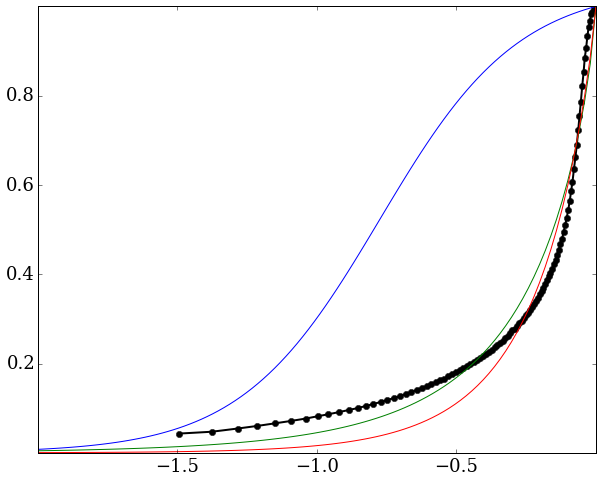

In [21]:
n_morph = len(questions[question]['answers'])

fractions = [question + '_' + s + '_weighted_fraction' for s in questions[question]['answers']]
counts = [question + '_' + s + '_count' for s in questions[question]['answers']]

m=0

p_values = np.log10(np.sort(data[fractions[m]]))
n = len(p_values)
cumfrac = np.linspace(0,1,n)
D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
D_fit = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)] # usually see a 'levelling off' at the
# low end, so don't fit this.


# Sample the cumulative histogram atequally spaced points in log_fv
#D_fit_log10fv = np.linspace(min_log_fv, 0, 10)
# Sample the cumulative histogram atequally spaced points in fv
D_fit_log10fv = np.log10(np.linspace((10**min_log_fv), 1, 100))
# Sample the cumulative histogram atequally spaced points in sqrt(fv)
#D_fit_log10fv = np.log10(np.linspace((10**min_log_fv)**(1/2.), 1, 10)**(2.))
indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
D_fit = D[indices]

plt.plot(D_fit['log10fv'],D_fit['cumfrac'],'k-o',linewidth=2)

x = np.linspace(-2,0,100)

p = (4, -3.1,1)
y = make_dictionaries.f_logistic(x, *p)
plt.plot(x, y)
print(((make_dictionaries.f_logistic(D_fit['log10fv'], *p) - D_fit['cumfrac'])**2).sum())

p = (3.1, 0.8,1)
y = make_dictionaries.f_exp_pow(x, *p)
plt.plot(x, y)
print(((make_dictionaries.f_exp_pow(D_fit['log10fv'], *p) - D_fit['cumfrac'])**2).sum())

p = (4.13, 0.91,1)
y = make_dictionaries.f_exp_pow(x, *p)
plt.plot(x, y)
print(((make_dictionaries.f_exp_pow(D_fit['log10fv'], *p) - D_fit['cumfrac'])**2).sum())

0 <function f_logistic at 0x2b3fdcaff2f0> [  6.00000000e+00  -4.11570385e-12   1.00000000e+00] 8.67983229687
0 <function f_exp_pow at 0x2b3fdcaff400> [ 3.07636761  0.61709098  1.20927394] 1.36115524003
exp. power function selected for a01_smooth (chisq=1.36)
1 <function f_logistic at 0x2b3fdcaff2f0> [ 1.75704119 -0.10022581  1.        ] 1.18499970604
1 <function f_exp_pow at 0x2b3fdcaff400> [ 1.13942165  1.11590739  1.        ] 1.49075437449
logistic function selected for a02_features_or_disk (chisq=1.18)
2 <function f_logistic at 0x2b3fdcaff2f0> [ 4.70691075 -7.5         1.00262971] 0.0291091836928
2 <function f_exp_pow at 0x2b3fdcaff400> [ 0.04903334  5.78884651  1.        ] 0.0134599919151
exp. power function selected for a03_star_or_artifact (chisq=0.0135)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10


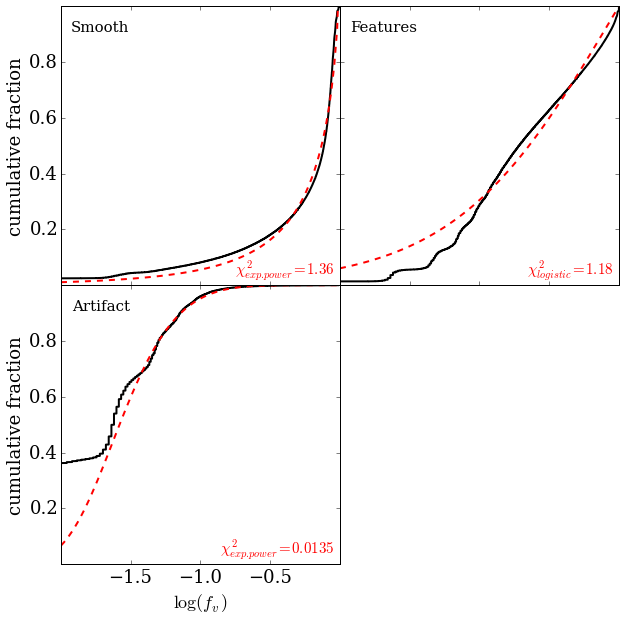

In [30]:
fit_setup = make_setup_dictionary(data,question,questions,function_dictionary,
                                  bin_assignments, vbin=None)

In [33]:
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question,questions)
# This part takes the longest (fitting curves to the data)

All bins fitted! 37.814650774002075s in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


{0: ((0.5, 6), (-7.5, 0), (1, 2)), 1: ((0.01, 5), (0.01, 10), (1, 2))}


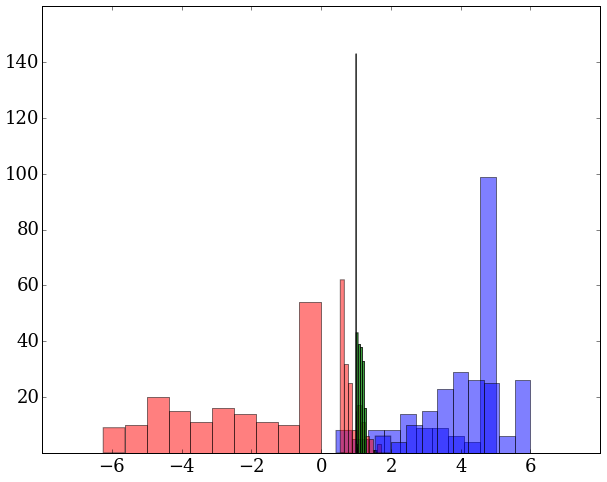

In [35]:
print(function_dictionary['bounds'])

for a in range(2):
    
    a_sel = fit_vbin_results['answer'] == a
    d_fit = fit_vbin_results[a_sel]
    
    plt.hist(fit_vbin_results[a_sel]['k'],color='b',alpha=0.5)
    plt.hist(fit_vbin_results[a_sel]['c'],color='r',alpha=0.5)
    plt.hist(fit_vbin_results[a_sel]['l'],color='g',alpha=0.75)

In [36]:
def plot_fit_vbin(question,questions,parameter='k', predictor=None):
    
    answerlabels = questions[question]['answerlabels']
    
    n_morph = len(questions[question]['answers'])
    fig, axarr = plt.subplots(n_morph, 3, sharey='row', sharex='col', figsize=(15,3*n_morph))
    def plot(ax, x, answer, colourby):
        r = fit_vbin_results[fit_vbin_results['answer'] == answer]
        if predictor is None:
            param = r[parameter]
        else:
            f, p = predictor
            var = np.array([r[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
            if p is not None:
                param = f(var, *p[answer])
            else:
                param = f(var)
        ax.scatter(r[x], param, c=r[colourby], marker='.', edgecolor='')
        y, bin_edges, binnumber = binned_statistic(r[x], r[parameter], statistic='median')
        xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(xc, y, 'k-')
        if predictor is not None:
            y, bin_edges, binnumber = binned_statistic(r[x], param, statistic='median')
            xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(xc, y, 'k--')
        low, high = plot_limits(r[parameter])
        ax.axis(ymin=low, ymax=high)
    for a, axrow in enumerate(axarr):
        plot(axrow[0], 'redshift', a, 'vbin')
        plot(axrow[1], 'R50', a, 'redshift')
        plot(axrow[2], 'Mr', a, 'redshift')
        axrow[0].set_ylabel("${}$ ({})".format(parameter,answerlabels[a]))
        if a == len(axarr) - 1:
            axrow[0].set_xlabel('$z$')
            axrow[1].set_xlabel('$\log_{10}{R_{50}}$')
            axrow[2].set_xlabel('$M_r$')
    fig.subplots_adjust(hspace=0, wspace=0)

In [37]:
def normalise(x):
    return (x - x.mean())/x.std()

fit_vbin_results['Mr_norm'] = normalise(fit_vbin_results['Mr'])
fit_vbin_results['R50_norm'] = normalise(fit_vbin_results['R50'])
fit_vbin_results['redshift_norm'] = normalise(fit_vbin_results['redshift'])

In [48]:
from scipy.optimize import curve_fit


def kcfunc(x, A0, AM, AR, Az):#,nz):
    # linear combination of (magnitude, size, redshift) + an offset
    #r = A0 + AM*x[0] + AR*np.log10(x[1]) + Az*(x[2]) 
    r = A0 + AM*(10**(x[0])) + AR*(x[1]) + Az*(x[2])
    return r


def fit_mrz(d, f=kcfunc,clip=None):
    # Fit a linear function of M, R and z to k and c

    answers = d['answer']
    answer_list = np.unique(answers)
    n_answers = len(answer_list)
    
    dout = d.copy()
    dout['kf'] = np.zeros(len(d))
    dout['cf'] = np.zeros(len(d))
    dout['lf'] = np.zeros(len(d))
    
    kparams = []
    cparams = []
    lparams = []
    
    kmin = [d[answers == a]['k'].min() for a in answer_list]
    kmax = [d[answers == a]['k'].max() for a in answer_list] 
    cmin = [d[answers == a]['c'].min() for a in answer_list]
    cmax = [d[answers == a]['c'].max() for a in answer_list] 
    lmin = [d[answers == a]['l'].min() for a in answer_list]
    lmax = [d[answers == a]['l'].max() for a in answer_list] 

    # Loop over GZ morphologies
    for a in answer_list:
        select = answers == a
        da = d[select]
        x = np.array([da[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
        k = da['k'].astype(np.float64)
        c = da['c'].astype(np.float64)
        l = da['l'].astype(np.float64)

        kp, kc = curve_fit(f, x, k, maxfev=100000)
        cp, cc = curve_fit(f, x, c, maxfev=100000)
        lp, lc = curve_fit(f,x,l,maxfev=100000)
        
        kres = f(x, *kp) - k
        knormres = normalise(kres)

        cres = f(x, *cp) - c
        cnormres = normalise(cres)
        
        lres = f(x, *cp) - l
        lnormres = normalise(lres)
        
        if clip != None:
        
            clipped = (np.absolute(knormres) < clip) & (np.absolute(cnormres) < clip) # 'clip' sigma clipping
            kp, kc = curve_fit(f, ((x.T)[clipped]).T, k[clipped], maxfev=100000)
            cp, cc = curve_fit(f, ((x.T)[clipped]).T, c[clipped], maxfev=100000)
            lp, lc = curve_fit(f, ((x.T)[clipped]).T, c[clipped], maxfev=100000)

        dout['kf'][select] = f(x, *kp)
        dout['cf'][select] = f(x, *cp)
        dout['lf'][select] = f(x, *lp)

        kparams.append(kp)
        cparams.append(cp)
        lparams.append(lp)
        
        plt.hist(knormres[clipped], alpha=0.4)
        plt.hist(cnormres[clipped], alpha=0.4)
        plt.hist(cnormres[clipped], alpha=0.4)
        plt.xlabel('residual')
        plt.ylabel('N')

    return kparams, cparams, lparams, dout, kmin, kmax, cmin, cmax,lmin,lmax

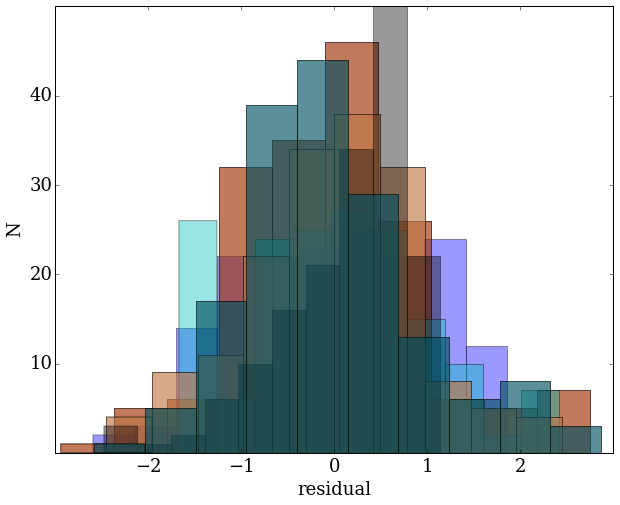

In [49]:
kparams, cparams,lparams,dout, kmin, kmax, cmin, cmax,lmin,lmax = fit_mrz(fit_vbin_results, kcfunc,clip=3)

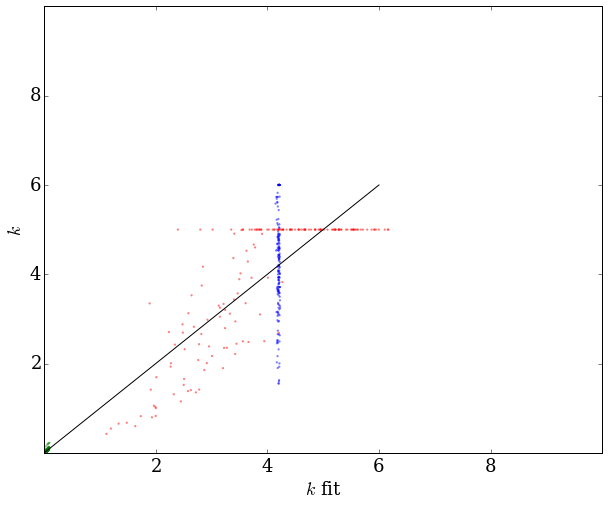

In [50]:
colours = 'rbgmc'
colours = [colours[i] for i in dout['answer']]

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.scatter(dout['kf'], dout['k'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['kf'], dout['k'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$k$ fit')
plt.ylabel('$k$')
_ = plt.axis((0, 10, 0, 10))

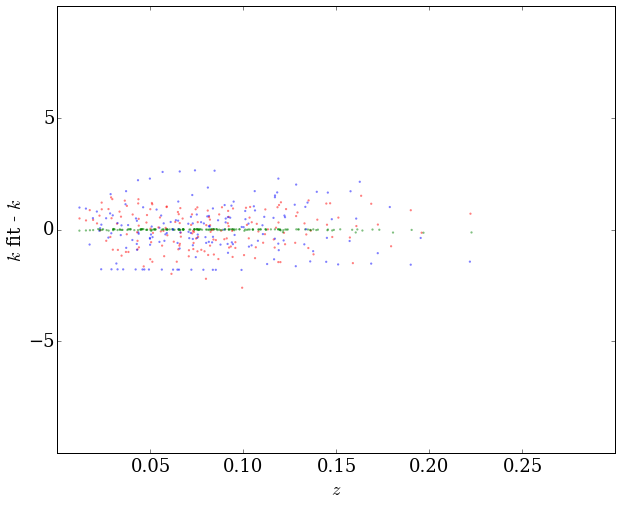

In [51]:
colours = 'rbgmc'
colours = [colours[i] for i in dout['answer']]

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.scatter(dout['redshift'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['kf'], dout['k'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
#plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$z$')
plt.ylabel('$k$ fit - $k$')
_ = plt.axis((0, 0.3, -10, 10))

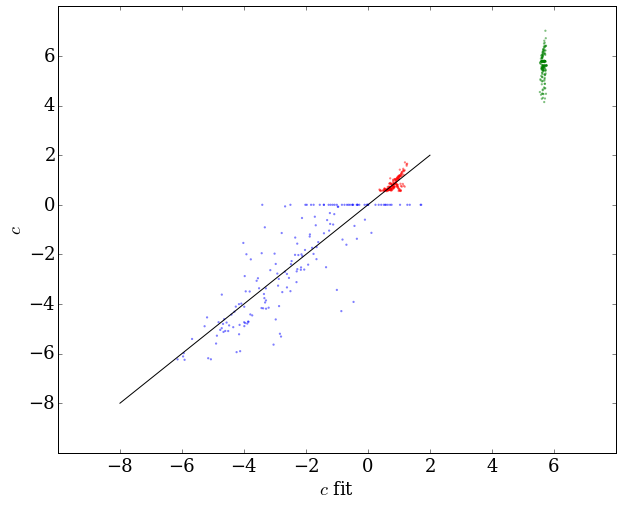

In [52]:
plt.scatter(dout['cf'], dout['c'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['cf'], dout['c'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
plt.plot([-8, 2], [-8, 2], 'k-')
plt.xlabel('$c$ fit')
plt.ylabel('$c$')
#_ = plt.axis((-11, 3, -11, 3))

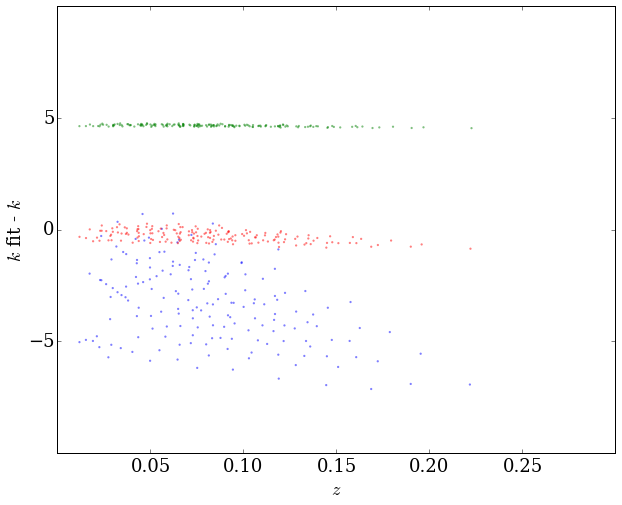

In [54]:
colours = 'rbgmc'
colours = [colours[i] for i in dout['answer']]

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.scatter(dout['redshift'], dout['lf']-dout['l'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['kf'], dout['k'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
#plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$z$')
plt.ylabel('$l$ fit - $l$')
_ = plt.axis((0, 0.3, -10, 10))

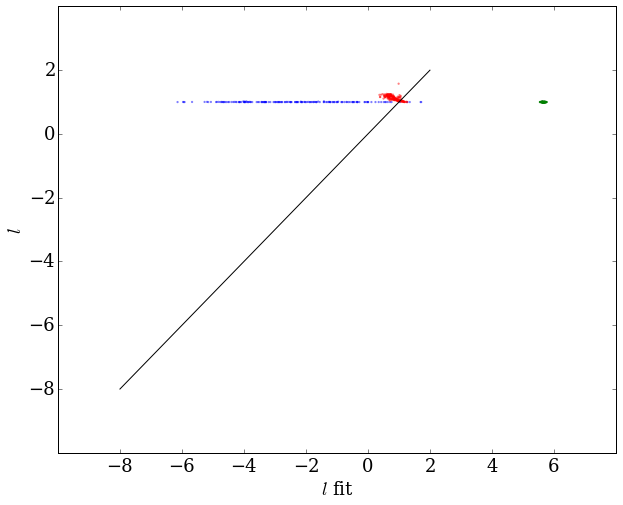

In [53]:
plt.scatter(dout['lf'], dout['l'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['cf'], dout['c'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
plt.plot([-8, 2], [-8, 2], 'k-')
plt.xlabel('$l$ fit')
plt.ylabel('$l$')
#_ = plt.axis((-11, 3, -11, 3))

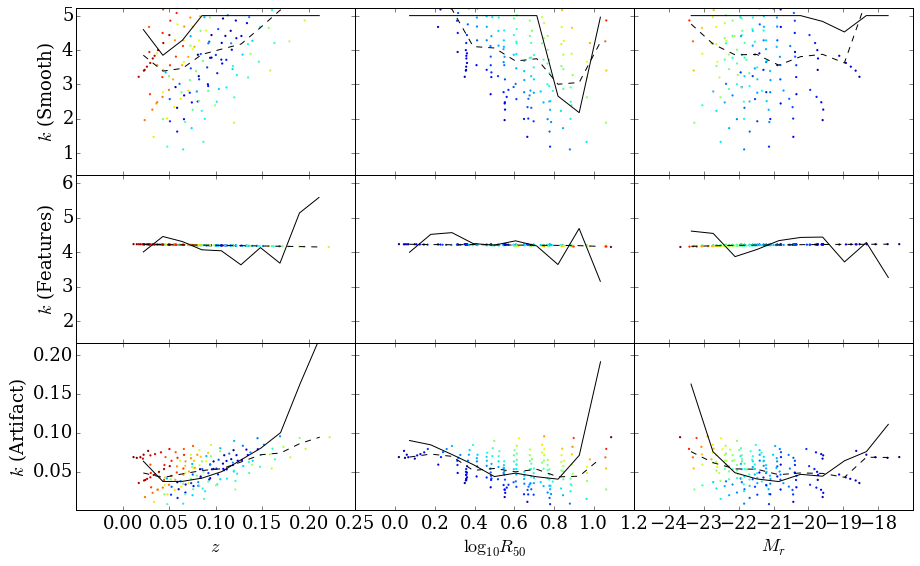

In [55]:
plot_fit_vbin(question,questions,'k', predictor=(kcfunc, kparams))
plt.savefig('figures/' + question + '/kc_fitted_functions/{}_k_x_fit1.pdf'.format(question))

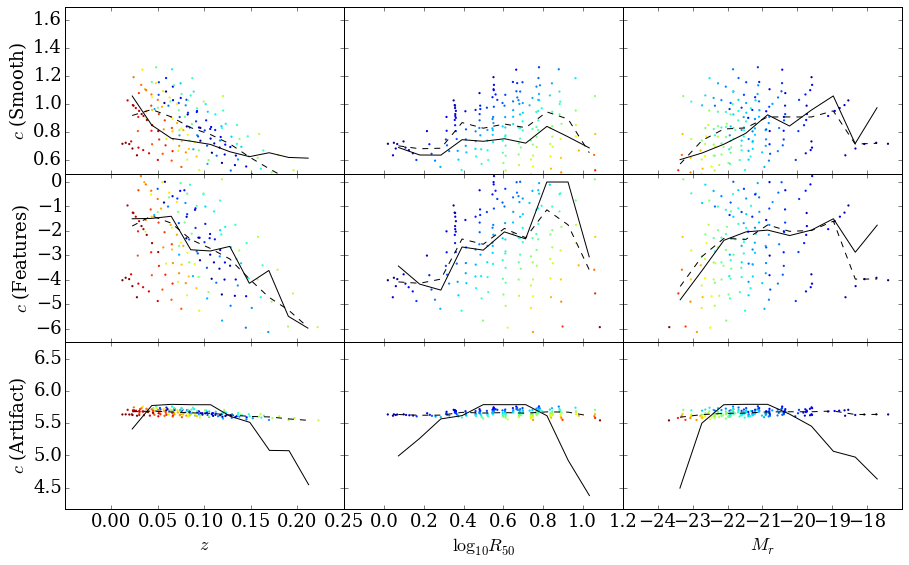

In [56]:
plot_fit_vbin(question,questions,'c', predictor=(kcfunc, cparams))

plt.savefig('figures/' + question + '/kc_fitted_functions/{}_c_x_fit1.pdf'.format(question))

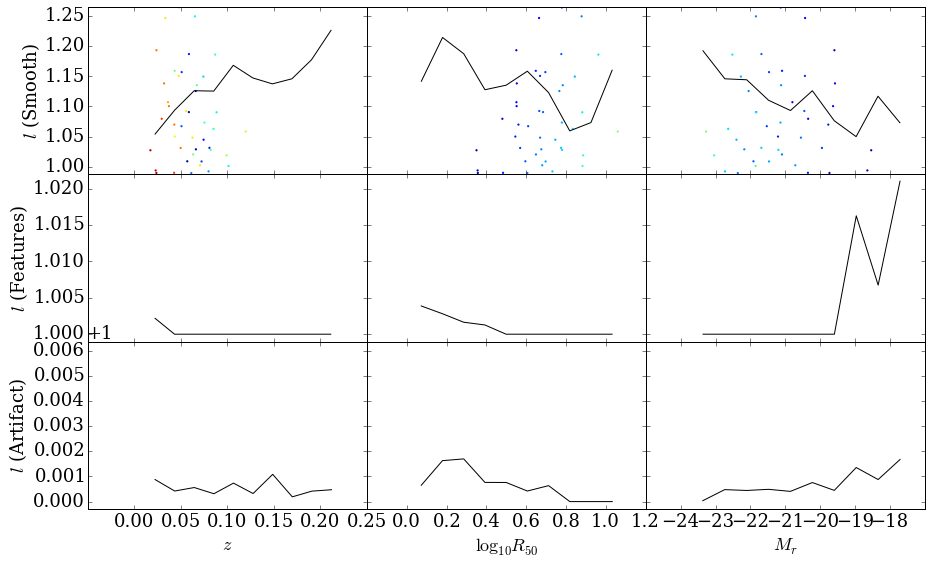

In [58]:
plot_fit_vbin(question,questions,'l', predictor=(kcfunc, lparams))

plt.savefig('figures/' + question + '/kc_fitted_functions/{}_c_x_fit1.pdf'.format(question))

In [65]:
# plot cumulative histograms with adopted fit
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question,questions,kc_fit_results=(kcfunc, kparams, cparams,lparams, 1))

All bins fitted! 38.04190254211426s in total


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


In [66]:
import pickle
os.mkdir('save_stuff/') if os.path.isdir('save_stuff/') is False else None
with open('save_stuff/kparams.p', 'wb') as f:
    pickle.dump(kparams, f)
with open('save_stuff/cparams.p', 'wb') as f:
    pickle.dump(cparams, f)
with open('save_stuff/fit_setup.p', 'wb') as f:
    pickle.dump(fit_setup, f)

In [67]:
def function_inversion(value,func,k,kb,c,cb):
    # for use when function has no mathematical inverse
    xg = np.log10(np.linspace(0.01,1,100))
    low_z_values = func(xg,kb,cb)
    high_z_value = func(value,k,c)
    i = (np.abs(low_z_values-high_z_value)).argmin()
    x = xg[i]
    return x

In [68]:
def debias(data, z_base, kcfunc, kparams, cparams,lparams,
           question,questions):
    # Debias the dataset
    answers = questions[question]['answers']
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    
    debiased = data[morph_fv_cols]

    # Each galaxy gets a function fit to its M,R and z parameters, which are scaled
    # to the equivalent M and r functions at low z.

    for m, fv_col in enumerate(morph_fv_cols):
        fv = debiased[fv_col]
        fv_nonzero = fv > 0
        log10fv = np.log10(np.asarray(fv[fv_nonzero]))
        func, _, _ = get_fit_setup(fit_setup, m)
        i_func = fit_setup['inverse'][m]
        bounds = fit_setup['bounds'][m]
        #------
        kmin = bounds[0][0]
        kmax = bounds[0][1]
        cmin = bounds[1][0]
        cmax = bounds[1][1]
        lmin = bounds[2][0]
        lmax = bounds[2][1]
        #-----
        d  = data[fv_nonzero]
        
        x = np.array([d['PETROMAG_MR'],
                      np.log10(d['PETROR50_R_KPC']),
                      d['REDSHIFT_1']], np.float64)
        xb  = x.copy()
        xb[-1] = z_base
        
        k = kcfunc(x, *kparams[m])
        c = kcfunc(x, *cparams[m])
        l = kcfunc(x, *lparams[m])
        
        k[k < kmin] = kmin
        k[k > kmax] = kmax
        c[c < cmin] = cmin
        c[c > cmax] = cmax
        l[l < lmin] = lmin
        c[l > lmax] = lmax

         #create version of x with all redshifts at z_base
        kb = kcfunc(xb, *kparams[m])
        cb = kcfunc(xb, *cparams[m])
        lb = kcfunc(xb, *lparams[m])
        
        kb[kb < kmin] = kmin
        kb[kb > kmax] = kmax
        cb[cb < cmin] = cmin
        cb[cb > cmax] = cmax
        lb[lb < lmin] = lmin
        lb[lb > lmax] = lmax
        
        # Need to deal with any values outside of the function limits here.
        
        if m == 100:
            
            bounds = fit_setup['bounds'][m]
            print(bounds)
            
            plt.subplot(2,1,1)
            plt.hist(kb,color='b',alpha=0.5,histtype='stepfilled')
            plt.hist(k,color='b',histtype='step',linewidth=2)
            plt.vlines(bounds[0][0],0,10**5,color='b')
            plt.vlines(bounds[0][1],0,10**5,color='b')
            
            plt.subplot(2,1,2)
            plt.hist(cb,color='r',histtype='stepfilled',alpha=0.5)
            plt.hist(c,color='r',histtype='step',linewidth=2)
            plt.vlines(bounds[1][0],0,10**5,color='r')
            plt.vlines(bounds[1][1],0,10**5,color='r')

        #possibly deal with any functions outside the k and c limits here
        if i_func == None:
            log10fv_debiased = np.array([function_inversion(log10fv[v],func,k[v],kb[v],c[v],cb[v]) 
                                         for v in range(len(log10fv))])
        
        else:
            cumfrac = func(log10fv, k, c,l)
            log10fv_debiased = i_func(cumfrac, kb, cb,lb)
        
        fv_debiased = 10**(log10fv_debiased)
        debiased[fv_col][fv_nonzero] = fv_debiased

    return debiased
    #return bounds

In [70]:
debiased = debias(data,0.03, kcfunc, kparams, cparams,lparams,
                  question,questions)

/home/ppxrh/Github_repos/Debiasing-testing-v2/Codes/make_dictionaries.py:35: RuntimeWarning: invalid value encountered in power
  x[ok] = -(-np.log(y[ok]) /k[ok] )**(1.0/c[ok])
/home/ppxrh/Github_repos/Debiasing-testing-v2/Codes/make_dictionaries.py:27: RuntimeWarning: invalid value encountered in log
  x = -(np.log(L / y - 1) - c) / k


In [76]:
# Do the debiasing of the FULL sample and the vl sample separately...

z_base = 0.03
    
def debias_fits(data,data_save):

    answers = questions[question]['answers']
    debiased = debias(data, z_base, kcfunc, kparams, cparams,lparams,
                  question,questions)
    
    for c in enumerate(debiased.colnames):
        fits_col = question + '_' + answers[c[0]] + '_debiased'
        #data_save[fits_col] = debiased[c[1]]

    return debiased

#debiased_full = debias_fits(all_data,all_data_save)
debiased = debias_fits(vl_data,vl_data_save)

In [39]:
vl_data_save.write(save_directory+'vl_sample_debiased.fits',overwrite=True)
all_data_save.write(save_directory+'full_sample_debiased.fits',overwrite=True)

In [72]:
def plot_debiased(data, debiased,question,questions,subsample=10):
    # Plot debiased values vs. raw values for comparison. Blue -> red with z.
    answers = questions[question]['answers']
    answerlabels = questions[question]['answerlabels']
    
    data = data[::subsample]
    debiased = debiased[::subsample]
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]

    fig, axarr = make_axes(n_morph=len(morph_fv_cols),xlabel='$f_{v,raw}$',ylabel='$f_{v,debiased}$')

    z = data['REDSHIFT_1']

    for m, fv_col in enumerate(morph_fv_cols):
        ax = axarr.ravel()[m]
        sc = ax.scatter(data[fv_col], debiased[fv_col],
                        marker=".", c=z, edgecolor='',
                        cmap=plt.cm.coolwarm,
                        norm=mpl.colors.LogNorm())

        ax.axis((0, 1, 0, 1))
        ax.plot([0,1],[0,1],"k-")

        ax.text(0.4, 0.9, answerlabels[m], fontsize='small', ha='left')

        if m > 2:
            ax.set_xlabel(r"$f_v$")
        if m == 0 or m == 3:
            ax.set_ylabel(r"$f_{v,\mathrm{debiased}}$")

    fig.subplots_adjust(hspace=0, wspace=0, right=0.85)

    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    cbar = fig.colorbar(sc, cax=cbar_ax, format='%.2f')
    cbar_ax.set_yticks([0.04,0.06,0.08])
    cbar.ax.set_ylabel('redshift')
    
    fig.savefig('figures/' + question +'/debiased_plots/debiased.pdf',dpi=100)

In [73]:
def plot_vf_histogram(debiased):
    # Plot histogram of sums of f_v.
    plt.figure()
    fv = np.array([debiased[c] for c in debiased.colnames], np.float)
    sums = np.sum(fv, axis=0)
    sums = sums[sums != 0]
    plt.hist(sums, bins=50, histtype='stepfilled', range=(0, 3))

    plt.xlabel(r"$\Sigma f_v$")
    plt.ylabel(r"$N_{gal}$")

    plt.savefig('figures/' + question + '/debiased_plots/vf_histogram.pdf')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/colorbar.py:215: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


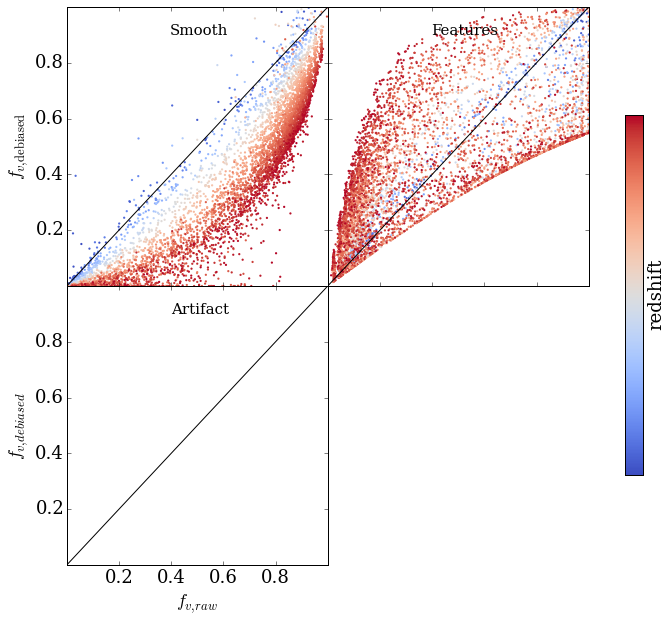

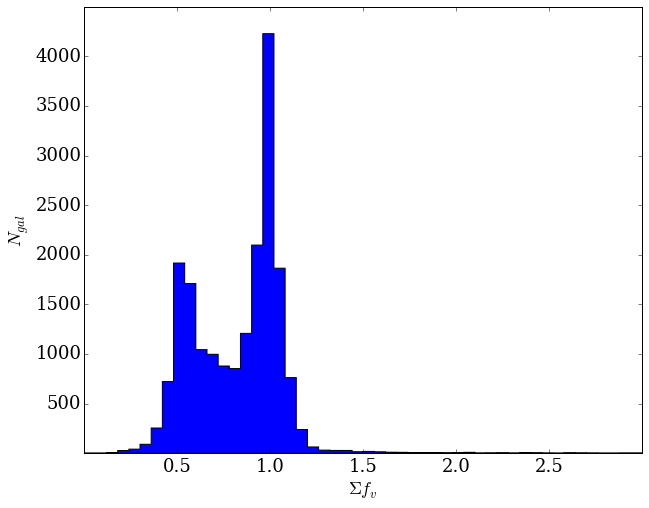

In [77]:
plot_debiased(vl_data,debiased,question,questions)
plot_vf_histogram(debiased)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in greater


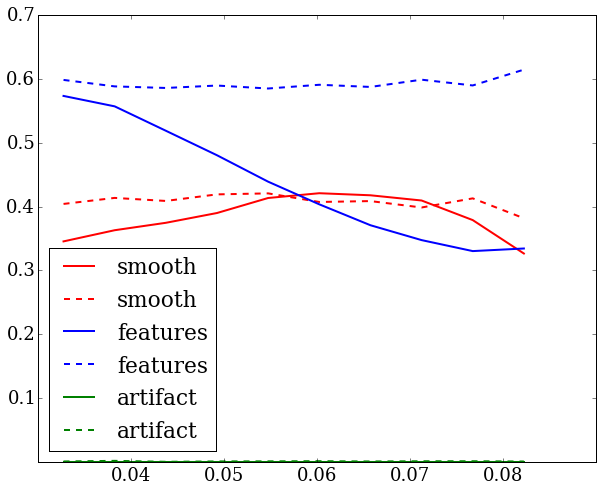

In [78]:
# Now need to plot a z-trend...
answers = questions[question]['answers']

norm = False

bins = np.linspace(0.03,0.085,11)
bin_centres = [bins[n]+(bins[n+1]-bins[n])/2 for n in range(len(bins)-1)]
bin_vals = np.digitize(vl_data['REDSHIFT_1'],bins=bins)

sum_deb = np.zeros(len(debiased))
for c in debiased.colnames:
    sum_deb = sum_deb + debiased[c]

n_morph = debiased.colnames
labels = ['smooth','features','artifact']

th = 0.5

clr = ['red','blue','green']

for m, morph in enumerate(n_morph):
    
    deb = debiased.copy()
    
    if norm == True:
        for c in debiased.colnames:
            deb[c] = debiased[c]/sum_deb # Normalise.
    
    fracs_deb = [np.sum(deb[bin_vals == b][morph] > th)/len(deb[bin_vals == b])
                 for b in np.unique(bin_vals)]
    
    w13 = Table([vl_data[question + '_' + a + '_debiased'] for a in answers])
    
    morph2 = w13.colnames
    
    fracs_w13 = [np.sum(w13[bin_vals == b][morph2[m]] > th)/len(w13[bin_vals == b])
                 for b in np.unique(bin_vals)]
    
    plt.plot(bin_centres,fracs_deb,label=labels[m],linewidth=2,color=clr[m])
    plt.plot(bin_centres,fracs_w13,label=labels[m],linewidth=2,linestyle='dashed',color=clr[m])
    plt.legend(loc=3)

(array([ 0.73149742,  1.26556647,  1.24228004,  1.17545814,  0.98967298,
         0.90412068,  0.7806014 ,  0.82616179,  0.87121596,  1.21342513]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 1 Patch objects>)

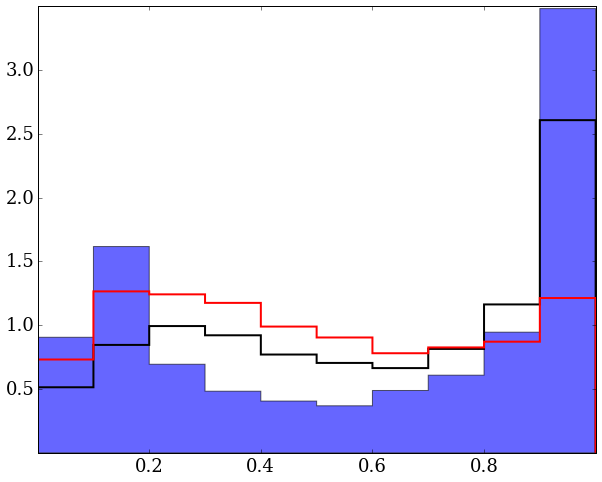

In [89]:
high_z = (vl_data['REDSHIFT_1'] >= 0.07) & (vl_data['REDSHIFT_1'] < 0.08)
low_z = (vl_data['REDSHIFT_1'] >= 0.03) & (vl_data['REDSHIFT_1'] < 0.04)

answer = 'a02_features_or_disk'

plt.hist(vl_data[low_z][question + '_' + answer + '_debiased'],bins=np.linspace(0,1,11)
         ,histtype='stepfilled',color='b',alpha=0.6,normed=True)

plt.hist(vl_data[high_z][question + '_' + answer + '_debiased'],bins=np.linspace(0,1,11)
         ,histtype='step',color='k',linewidth=2,normed=True)

plt.hist(debiased[high_z][question + '_' + answer + '_weighted_fraction'],bins=np.linspace(0,1,11)
         ,histtype='step',color='r',linewidth=2,normed=True)